In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
import glob
import math
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
import seaborn as sns
pd.options.mode.chained_assignment = None
from matplotlib import colors
style.use("seaborn-whitegrid") or plt.style.use("seaborn-whitegrid")


In [2]:
sim = 'Martin2012'
label = '(c)'

In [3]:
# Define a function to cut colormap

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


In [4]:
# Read in grounding line

dfGL = pd.read_csv("/Users/clara.henry/Documents/Derwael/Data/GroundingLine.csv")

points = np.column_stack((list(dfGL["Points:0"])[::10], list(dfGL["Points:1"])[::10]))

alpha = 0.95 * alphashape.optimizealpha(points)
hull = alphashape.alphashape(points, alpha)
hull_pts = hull.exterior.coords.xy

for i in range(len(hull_pts[0])):
    hull_pts[0][i] = hull_pts[0][i]
    hull_pts[1][i] = hull_pts[1][i]
    
poly = Polygon(zip(list(hull_pts[0]), list(hull_pts[1])))
    

/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)
/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/alphashape/optimizealpha.py:41: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return all([polygon.intersects(point) for point in points])


In [5]:
# Here we investigate physical fields at an elevation of z=0.
# N.B.: Be aware that the list name "IsochroneAges" and column title is misleading, 
# as in this case we are not calculating at an isochrone but at a constant elevation.

IsochroneAges = [0]
CSs = {}

CSs['Age0'] = pd.read_csv('../../ModelOutputData/z0/' + sim + '/z0.csv')


In [6]:

add_columns = ['a_lambda1', 'a_lambda2', 'a_lambda3', 'a_ev1x', 'a_ev1y', 'a_ev1z', \
               'a_ev2x', 'a_ev2y', 'a_ev2z', 'a_ev3x', 'a_ev3y', 'a_ev3z', \
               'a_lambda1_H', 'a_lambda2_H', 'a_ev1x_H', 'a_ev1y_H', 'a_ev2x_H', 'a_ev2y_H', \
               'd_lambda1', 'd_lambda2', 'd_lambda3', 'd_ev1x', 'd_ev1y', 'd_ev1z', \
               'd_ev2x', 'd_ev2y', 'd_ev2z', 'd_ev3x', 'd_ev3y', 'd_ev3z', \
               'd_lambda1_H', 'd_lambda2_H', 'd_ev1x_H', 'd_ev1y_H', 'd_ev2x_H', 'd_ev2y_H',\
               'theta', 'w mag', 'a_lambda2 - a_lambda1', 'theta_a_d']

for i in IsochroneAges:
    for j in add_columns:
        CSs['Age' + str(i)][j] = np.nan


In [7]:

xmin, xmax = min(CSs['Age0']['Points:0']), max(CSs['Age0']['Points:0'])
ymin, ymax = min(CSs['Age0']['Points:1']), max(CSs['Age0']['Points:1'])
dist = 100
nx, ny = int((xmax - xmin)/dist + 1), int((ymax - ymin)/dist + 1)
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
grid_x, grid_y = np.meshgrid(x, y)


In [8]:

for i in IsochroneAges:
    values = CSs['Age' + str(i)][['a2 1', 'a2 4', 'a2 5', 'a2 4', 'a2 2', 'a2 6', \
                                  'a2 5', 'a2 6', 'a2 3']].values.reshape(-1,3)
    eigs = LA.eigh(values.reshape((-1, 3, 3)))
    CSs['Age' + str(i)]['a_lambda1'] = eigs[0][:,0]
    CSs['Age' + str(i)]['a_lambda2'] = eigs[0][:,1]
    CSs['Age' + str(i)]['a_lambda3'] = eigs[0][:,2]
    
    CSs['Age' + str(i)]['a_ev1x'] = eigs[1][:,0,0]
    CSs['Age' + str(i)]['a_ev1y'] = eigs[1][:,0,1]
    CSs['Age' + str(i)]['a_ev1z'] = eigs[1][:,0,2]
    CSs['Age' + str(i)]['a_ev2x'] = eigs[1][:,1,0]
    CSs['Age' + str(i)]['a_ev2y'] = eigs[1][:,1,1]
    CSs['Age' + str(i)]['a_ev2z'] = eigs[1][:,1,2]
    CSs['Age' + str(i)]['a_ev3x'] = eigs[1][:,2,0]
    CSs['Age' + str(i)]['a_ev3y'] = eigs[1][:,2,1]
    CSs['Age' + str(i)]['a_ev3z'] = eigs[1][:,2,2]


In [9]:
# Calculate horizontal eigenvalues and eigenvectors

for i in IsochroneAges:
    values = CSs['Age' + str(i)][['a2 1', 'a2 4', 'a2 4', 'a2 2']].values.reshape(-1,2)
    eigs = LA.eigh(values.reshape((-1, 2, 2)))
    CSs['Age' + str(i)]['a_lambda1_H'] = eigs[0][:,0]
    CSs['Age' + str(i)]['a_lambda2_H'] = eigs[0][:,1]
    
    CSs['Age' + str(i)]['a_ev1x_H'] = eigs[1][:,0,0]
    CSs['Age' + str(i)]['a_ev1y_H'] = eigs[1][:,0,1]
    CSs['Age' + str(i)]['a_ev2x_H'] = eigs[1][:,1,0]
    CSs['Age' + str(i)]['a_ev2y_H'] = eigs[1][:,1,1]


In [10]:

for i in IsochroneAges:
    CSs['Age' + str(i)]['theta'] = np.arccos(CSs['Age' + str(i)]['a_ev3z'])
    CSs['Age' + str(i)]['theta'] = np.where(CSs['Age' + str(i)]['theta'] < np.pi/2, \
                                            CSs['Age' + str(i)]['theta'], \
                                            np.pi - CSs['Age' + str(i)]['theta'])
    CSs['Age' + str(i)]['theta_deg'] = np.rad2deg(CSs['Age' + str(i)]['theta'])


In [11]:

for i in IsochroneAges:
    values = CSs['Age' + str(i)][['d 1', 'd 4', 'd 5', 'd 4', 'd 2', 'd 6', \
                                  'd 5', 'd 6', 'd 3']].values.reshape(-1,3)
    eigs = LA.eigh(values.reshape((-1, 3, 3)))
    CSs['Age' + str(i)]['d_lambda1'] = eigs[0][:,0]
    CSs['Age' + str(i)]['d_lambda2'] = eigs[0][:,1]
    CSs['Age' + str(i)]['d_lambda3'] = eigs[0][:,2]
    
    CSs['Age' + str(i)]['d_ev1x'] = eigs[1][:,0,0]
    CSs['Age' + str(i)]['d_ev1y'] = eigs[1][:,0,1]
    CSs['Age' + str(i)]['d_ev1z'] = eigs[1][:,0,2]
    CSs['Age' + str(i)]['d_ev2x'] = eigs[1][:,1,0]
    CSs['Age' + str(i)]['d_ev2y'] = eigs[1][:,1,1]
    CSs['Age' + str(i)]['d_ev2z'] = eigs[1][:,1,2]
    CSs['Age' + str(i)]['d_ev3x'] = eigs[1][:,2,0]
    CSs['Age' + str(i)]['d_ev3y'] = eigs[1][:,2,1]
    CSs['Age' + str(i)]['d_ev3z'] = eigs[1][:,2,2]
    

In [12]:

for i in IsochroneAges:
    values = CSs['Age' + str(i)][['d 1', 'd 4', 'd 4', 'd 2']].values.reshape(-1,2)
    eigs = LA.eigh(values.reshape((-1, 2, 2)))
    CSs['Age' + str(i)]['d_lambda1_H'] = eigs[0][:,0]
    CSs['Age' + str(i)]['d_lambda2_H'] = eigs[0][:,1]
    
    CSs['Age' + str(i)]['d_ev1x_H'] = eigs[1][:,0,0]
    CSs['Age' + str(i)]['d_ev1y_H'] = eigs[1][:,0,1]
    CSs['Age' + str(i)]['d_ev2x_H'] = eigs[1][:,1,0]
    CSs['Age' + str(i)]['d_ev2y_H'] = eigs[1][:,1,1]
    

In [13]:
# Calculate the angle between the eigenvectors corresponding to the maximum horizontal anisotropy 
# eigenvector and the maximum horizontal strain rate eigenvector

for i in IsochroneAges:
    CSs['Age' + str(i)]['theta_a_d'] = np.arccos(CSs['Age' + str(i)]['a_ev2x_H'] \
                                                 * CSs['Age' + str(i)]['d_ev2x_H'] \
                                                 + CSs['Age' + str(i)]['a_ev2y_H'] \
                                                 * CSs['Age' + str(i)]['d_ev2y_H'])
    CSs['Age' + str(i)]['theta_a_d'] = np.where(CSs['Age' + str(i)]['theta_a_d'] < np.pi/2, \
                                                CSs['Age' + str(i)]['theta_a_d'], \
                                                np.pi - CSs['Age' + str(i)]['theta_a_d'])


In [14]:
# Calculate magnitude of the vorticity vector

for i in IsochroneAges:
    CSs['Age' + str(i)]['w mag'] = np.sqrt(CSs['Age' + str(i)]['w 1']**2 + CSs['Age' + str(i)]['w 2']**2 + CSs['Age' + str(i)]['w 3']**2)


In [15]:
# Calculate the difference between lambda1 and lambda2

for i in IsochroneAges:
    CSs['Age' + str(i)]['a_lambda2_H - a_lambda1_H'] = CSs['Age' + str(i)]['a_lambda2_H'] - CSs['Age' + str(i)]['a_lambda1_H']


In [16]:
# Calculate the difference and the percentage differences between the 
# smaller 3D eigenvalues and the horizontal eigenvalues

for i in IsochroneAges:
    CSs['Age' + str(i)]['a_lambda2 - a_lambda2_H'] = CSs['Age' + str(i)]['a_lambda2'] - \
                                                     CSs['Age' + str(i)]['a_lambda2_H']
    CSs['Age' + str(i)]['a_lambda1 - a_lambda1_H'] = CSs['Age' + str(i)]['a_lambda1'] - \
                                                     CSs['Age' + str(i)]['a_lambda1_H']
    CSs['Age' + str(i)]['a_lambda2 - a_lambda2_H perc.'] = 200 * (CSs['Age' + str(i)]['a_lambda2'] - \
                                                     CSs['Age' + str(i)]['a_lambda2_H']) / \
                                                    (CSs['Age' + str(i)]['a_lambda2'] + \
                                                     CSs['Age' + str(i)]['a_lambda2_H'])
    CSs['Age' + str(i)]['a_lambda1 - a_lambda1_H perc.'] = 200 * (CSs['Age' + str(i)]['a_lambda1'] - \
                                                     CSs['Age' + str(i)]['a_lambda1_H']) / \
                                                    (CSs['Age' + str(i)]['a_lambda1'] + \
                                                     CSs['Age' + str(i)]['a_lambda1_H'])


In [17]:
# Calculate the Woodcock k number

for i in IsochroneAges:
    CSs['Age' + str(i)]['k'] = np.log(CSs['Age' + str(i)]['a_lambda3'] / CSs['Age' + str(i)]['a_lambda2']) \
                                      / np.log(CSs['Age' + str(i)]['a_lambda2'] / CSs['Age' + str(i)]['a_lambda1'])
    CSs['Age' + str(i)]['ln k'] = np.log(np.log(CSs['Age' + str(i)]['a_lambda3'] / CSs['Age' + str(i)]['a_lambda2']) \
                                      / np.log(CSs['Age' + str(i)]['a_lambda2'] / CSs['Age' + str(i)]['a_lambda1']))    


/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
# Calculate the components for the Woodcock figure

for i in IsochroneAges:
    CSs['Age' + str(i)]['girdle'] = np.log(CSs['Age' + str(i)]['a_lambda2'] / CSs['Age' + str(i)]['a_lambda1'])
    CSs['Age' + str(i)]['single max'] = np.log(CSs['Age' + str(i)]['a_lambda3'] / CSs['Age' + str(i)]['a_lambda2'])


In [19]:
# Define dictionaries to store gridded data

axx = {}
ayy = {}
azz = {}
theta = {}
theta_a_d = {}
a_lambda1 = {}
a_lambda2 = {}
a_lambda3 = {}
a_lambda1_subtract = {}
a_lambda2_subtract = {}
a_lambda1_perc_subtract = {}
a_lambda2_perc_subtract = {}
k = {}
lnk = {}
w_mag = {}
d_ev1x_H = {}
d_ev1y_H = {}
d_ev2x_H = {}
d_ev2y_H = {}
d_lambda1_H = {}
d_lambda2_H ={}
a_ev1x_H = {}
a_ev1y_H = {}
a_ev2x_H = {}
a_ev2y_H = {}
a_lambda1_H = {}
a_lambda2_H ={}
a_lambda2_1_H = {}
w1 = {}
w2 = {}
w3 = {}
depth = {}
girdle = {}
single_max = {}

for i in IsochroneAges:
    axx['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a2 1'], (grid_x, grid_y), method='linear')
    ayy['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a2 2'], (grid_x, grid_y), method='linear')
    azz['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a2 3'], (grid_x, grid_y), method='linear')
    theta['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['theta'], (grid_x, grid_y), method='linear')
    theta_a_d['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['theta_a_d'], (grid_x, grid_y), method='linear')
    a_lambda1['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a_lambda1'], (grid_x, grid_y), method='linear')
    a_lambda2['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a_lambda2'], (grid_x, grid_y), method='linear')
    a_lambda3['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a_lambda3'], (grid_x, grid_y), method='linear')
    a_lambda1_subtract['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a_lambda1 - a_lambda1_H'], (grid_x, grid_y), method='linear')
    a_lambda2_subtract['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a_lambda2 - a_lambda2_H'], (grid_x, grid_y), method='linear')
    a_lambda1_perc_subtract['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a_lambda1 - a_lambda1_H perc.'], (grid_x, grid_y), method='linear')
    a_lambda2_perc_subtract['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a_lambda2 - a_lambda2_H perc.'], (grid_x, grid_y), method='linear')
    k['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['k'], (grid_x, grid_y), method='linear')
    lnk['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['ln k'], (grid_x, grid_y), method='linear')
    w_mag['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['w mag'], (grid_x, grid_y), method='linear')
    d_ev1x_H['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['d_ev1x_H'], (grid_x, grid_y), method='linear')
    d_ev1y_H['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['d_ev1y_H'], (grid_x, grid_y), method='linear')
    d_ev2x_H['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['d_ev2x_H'], (grid_x, grid_y), method='linear')
    d_ev2y_H['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['d_ev2y_H'], (grid_x, grid_y), method='linear')
    d_lambda1_H['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['d_lambda1_H'], (grid_x, grid_y), method='linear')
    d_lambda2_H['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['d_lambda2_H'], (grid_x, grid_y), method='linear')
    a_ev1x_H['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a_ev1x_H'], (grid_x, grid_y), method='linear')
    a_ev1y_H['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a_ev1y_H'], (grid_x, grid_y), method='linear')
    a_ev2x_H['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a_ev2x_H'], (grid_x, grid_y), method='linear')
    a_ev2y_H['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a_ev2y_H'], (grid_x, grid_y), method='linear')
    a_lambda1_H['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a_lambda1_H'], (grid_x, grid_y), method='linear')
    a_lambda2_H['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a_lambda2_H'], (grid_x, grid_y), method='linear')
    a_lambda2_1_H['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['a_lambda2_H - a_lambda1_H'], (grid_x, grid_y), method='linear')
    w1['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['w 1'], (grid_x, grid_y), method='linear')
    w2['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['w 2'], (grid_x, grid_y), method='linear')
    w3['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['w 3'], (grid_x, grid_y), method='linear')
    depth['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['depth'], (grid_x, grid_y), method='linear')
    girdle['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['girdle'], (grid_x, grid_y), method='linear')
    single_max['Age' + str(i)] = scipy.interpolate.griddata((CSs['Age' + str(i)]["Points:0"], CSs['Age' + str(i)]["Points:1"]), CSs['Age' + str(i)]['single max'], (grid_x, grid_y), method='linear')


In [20]:

for i in range(len(hull_pts[0])):
    hull_pts[0][i] = hull_pts[0][i]/1000
    hull_pts[1][i] = hull_pts[1][i]/1000


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/2036911450.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1.0])


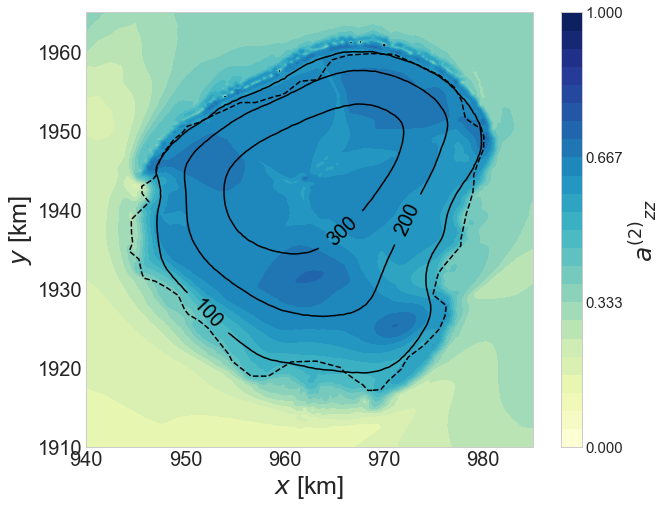

In [21]:

inter = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, azz['Age0'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax.plot(hull_pts[0], hull_pts[1], linestyle="--", color='black')
ax.clabel(CS2, inline=True, fontsize=20, colors=['black'])
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.tick_params(axis='both', which='major', labelsize=20)
#ax.set_aspect('equal', size=25)
plt.xlim(940, 985)
plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1.0])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"${a^{(2)}}_{zz}$", rotation=90, size=25)
fig.savefig('../../Figures/a_zz_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/598009101.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1.0])


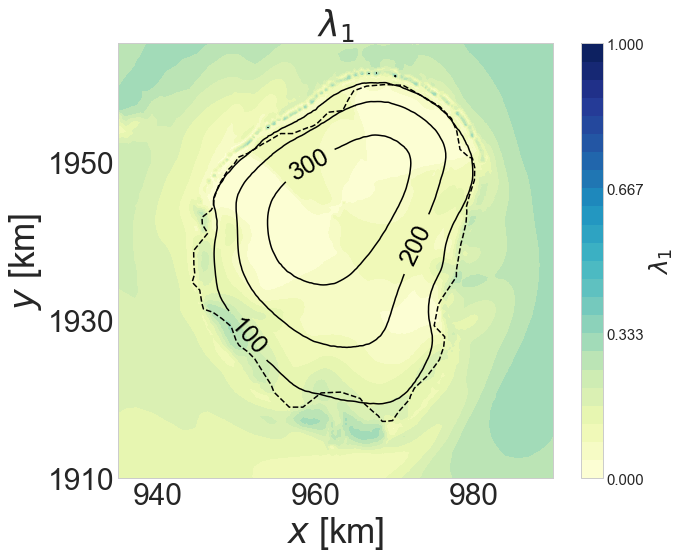

In [22]:

inter = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, a_lambda1['Age0'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax.plot(hull_pts[0], hull_pts[1], linestyle="--", color='black')
ax.clabel(CS2, inline=True, fontsize=25, colors=['black'])
ax.set_xlabel(r'$x$ [km]', size=35)
ax.set_ylabel(r'$y$ [km]', size=35)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.set_aspect('equal')
ax.set_title(r"$\lambda_1$", size=35)
plt.xlim(935, 990)
plt.ylim(1910, 1965)
ax.set_yticks([1910,1930,1950])
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1.0])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\lambda_1$", rotation=90, size=25)
fig.savefig('../../Figures/a_lambda1_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/1645696571.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1.0])


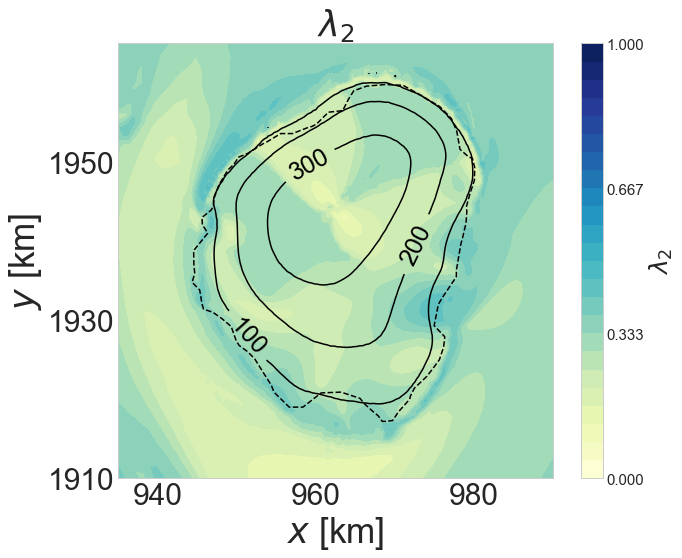

In [23]:

inter = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, a_lambda2['Age0'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax.plot(hull_pts[0], hull_pts[1], linestyle="--", color='black')
ax.clabel(CS2, inline=True, fontsize=25, colors=['black'])
ax.set_xlabel(r'$x$ [km]', size=35)
ax.set_ylabel(r'$y$ [km]', size=35)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.set_aspect('equal')
ax.set_title(r"$\lambda_2$", size=35)
plt.xlim(935, 990)
plt.ylim(1910, 1965)
ax.set_yticks([1910,1930,1950])
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1.0])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\lambda_2$", rotation=90, size=25)
fig.savefig('../../Figures/a_lambda2_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/2272335770.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1.0])


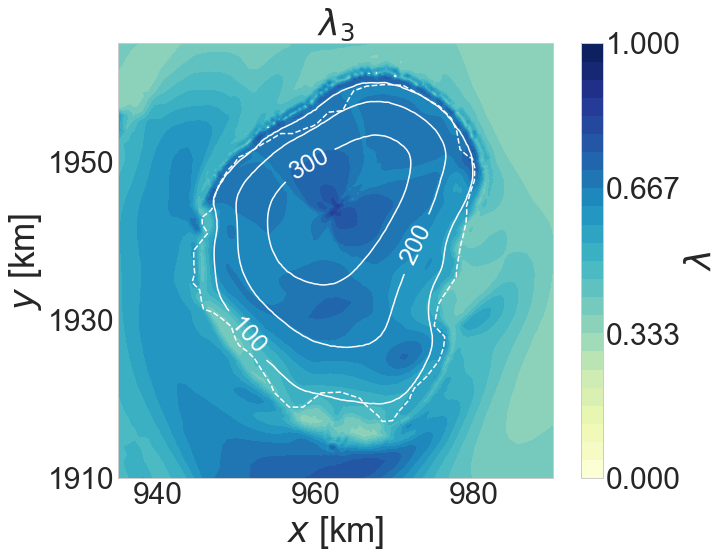

In [24]:

inter = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, a_lambda3['Age0'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['white'])
ax.plot(hull_pts[0], hull_pts[1], linestyle="--", color='white')
ax.clabel(CS2, inline=True, fontsize=25, colors=['white'])
ax.set_xlabel(r'$x$ [km]', size=35)
ax.set_ylabel(r'$y$ [km]', size=35)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.set_aspect('equal')
ax.set_title(r"$\lambda_3$", size=35)
plt.xlim(935, 990)
plt.ylim(1910, 1965)
ax.set_yticks([1910,1930,1950])
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1.0])
cbar.ax.tick_params(labelsize=30)
cbar.set_label(r"$\lambda$", rotation=90, size=35)
fig.savefig('../../Figures/a_lambda3_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/1229491890.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS, cax=cbar_ax, ticks=[0.0, 0.333, 0.667, 1.0])


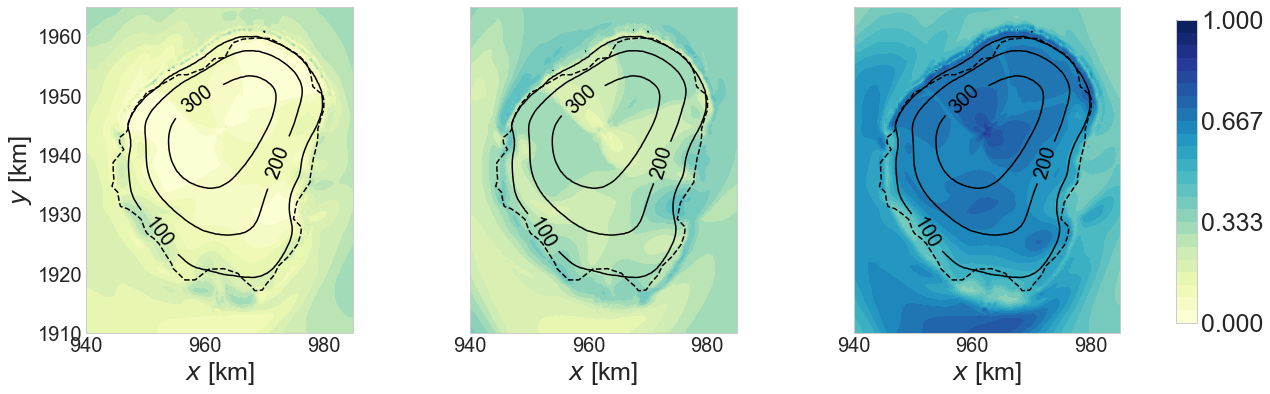

In [25]:

fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
CS = ax[0].contourf(x/1000, y/1000, a_lambda1['Age0'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
CS2 = ax[0].contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax[0].plot(hull_pts[0], hull_pts[1], linestyle="--", color='black')
ax[0].clabel(CS2, inline=True, fontsize=20, colors=['black'])
ax[0].set_xlabel(r'$x$ [km]', size=25)
ax[0].set_ylabel(r'$y$ [km]', size=25)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_aspect('equal')
ax[0].set_xlim(940, 985)
ax[0].set_ylim(1910, 1965)

ax[1].contourf(x/1000, y/1000, a_lambda2['Age0'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
CS2 = ax[1].contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax[1].plot(hull_pts[0], hull_pts[1], linestyle="--", color='black')
ax[1].clabel(CS2, inline=True, fontsize=20, colors=['black'])
ax[1].set_xlabel(r'$x$ [km]', size=25)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_aspect('equal')
ax[1].set_xlim(940, 985)
ax[1].set_ylim(1910, 1965)

ax[2].contourf(x/1000, y/1000, a_lambda3['Age0'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
CS2 = ax[2].contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax[2].plot(hull_pts[0], hull_pts[1], linestyle="--", color='black')
ax[2].clabel(CS2, inline=True, fontsize=20, colors=['black'])
ax[2].set_xlabel(r'$x$ [km]', size=25)
ax[2].tick_params(axis='both', which='major', labelsize=20)
ax[2].set_aspect('equal')
ax[2].set_xlim(940, 985)
ax[2].set_ylim(1910, 1965)

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar_ax.set_label(r"$\lambda_1$")
cbar_ax.tick_params(labelsize=25)

#cbar_ax.label(r"$\lambda_3$", rotation=90, size=25)
fig.colorbar(CS, cax=cbar_ax, ticks=[0.0, 0.333, 0.667, 1.0])


#fig.savefig('../Figures/a_lambda1_z0Iota1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/3243405545.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1.0])


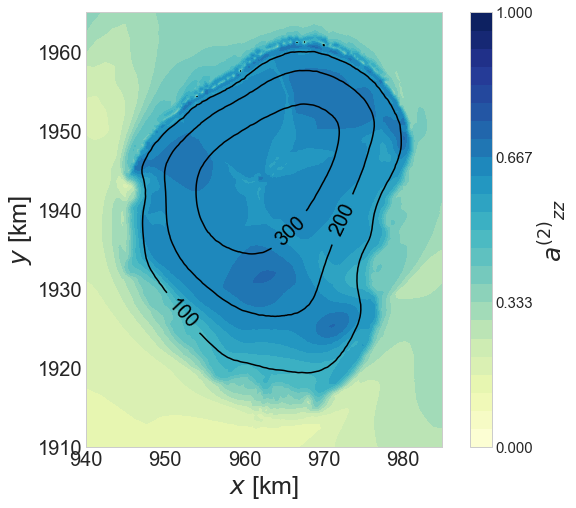

In [26]:

inter = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, azz['Age0'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax.clabel(CS2, inline=True, fontsize=20, colors=['black'])
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_aspect('equal')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667, 1.0])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"${a^{(2)}}_{zz}$", rotation=90, size=25)
fig.savefig('../../Figures/a_zz_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/2369608055.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, np.pi/4])


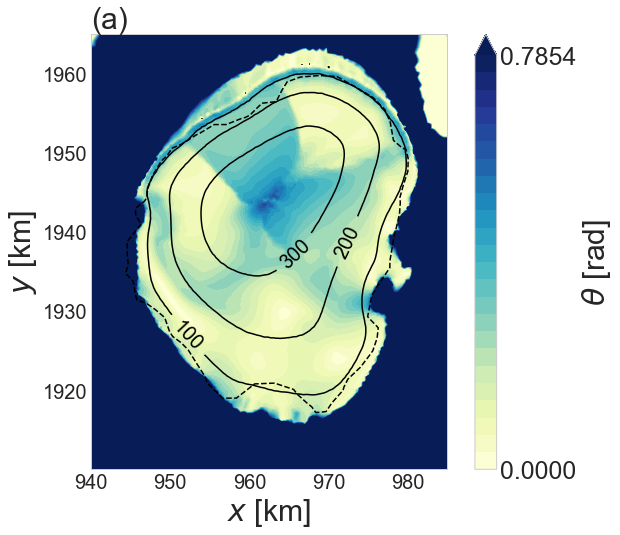

In [27]:

inter = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, theta['Age0'], levels=np.linspace(0,np.pi/4,25),  cmap='YlGnBu', extend='max')
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax.plot(hull_pts[0], hull_pts[1], linestyle="--", color='black')
ax.set_title('(a)', size=30, loc='left')
ax.clabel(CS2, inline=True, fontsize=20, colors=['black'])
ax.set_xlabel(r'$x$ [km]', size=30)
ax.set_ylabel(r'$y$ [km]', size=30)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_aspect('equal')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
ax.set_yticks([1920, 1930, 1940, 1950, 1960])
cbar = fig.colorbar(CS, ticks=[0.0, np.pi/4])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r"$\theta$ [rad]", rotation=90, size=30)
fig.savefig('../../Figures/angle_deviation_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/1781548402.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, np.pi/4, np.pi/2])


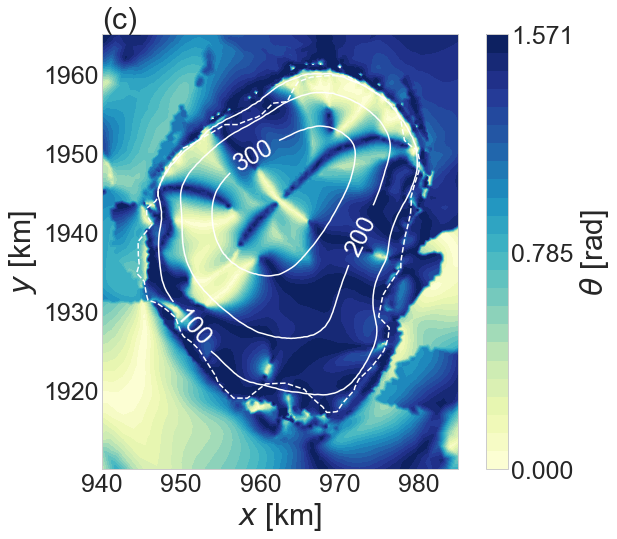

In [28]:

inter = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, theta_a_d['Age0'], levels=np.linspace(0,np.pi/2,25),  cmap='YlGnBu')
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['white'])
ax.plot(hull_pts[0], hull_pts[1], linestyle="--", color='white')
ax.clabel(CS2, inline=True, fontsize=25, colors=['white'])
ax.set_xlabel(r'$x$ [km]', size=30)
ax.set_ylabel(r'$y$ [km]', size=30)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_aspect('equal')
ax.set_title(label, size=30, loc='left')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
ax.set_xticks([940, 950, 960, 970, 980])
ax.set_yticks([1920, 1930, 1940, 1950, 1960])
cbar = fig.colorbar(CS, ticks=[0.0, np.pi/4, np.pi/2])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r"$\theta$ [rad]", rotation=90, size=30)
fig.savefig('../../Figures/sr_aniso_angle_deviation_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/3477546634.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667])


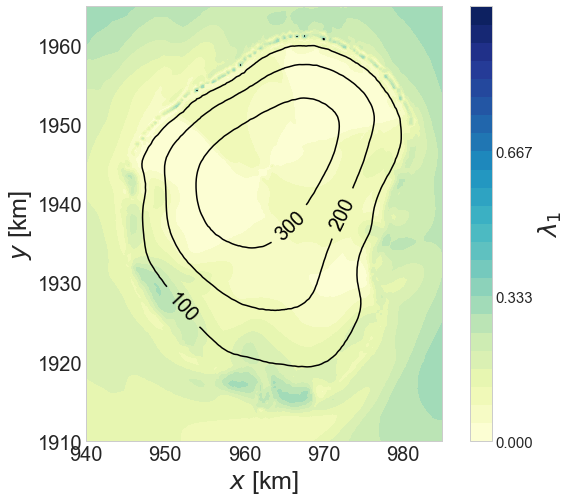

In [29]:
 
inter = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, a_lambda1['Age0'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax.clabel(CS2, inline=True, fontsize=20, colors=['black'])
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_aspect('equal')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\lambda_1$", rotation=90, size=25)
fig.savefig('../../Figures/lambda1_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/1997052484.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667])


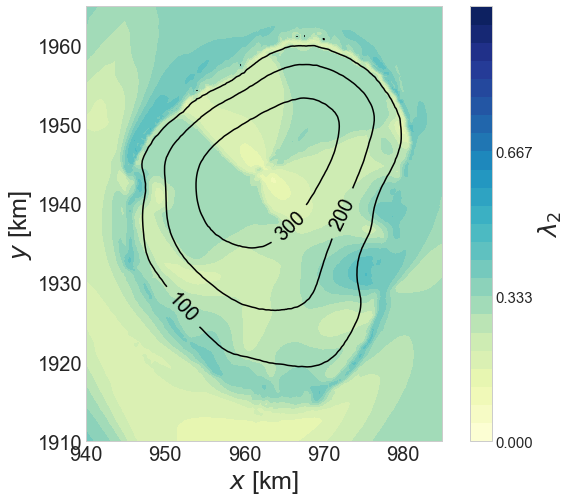

In [30]:
 
inter = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, a_lambda2['Age0'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax.clabel(CS2, inline=True, fontsize=20, colors=['black'])
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_aspect('equal')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\lambda_2$", rotation=90, size=25)
fig.savefig('../../Figures/lambda2_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")
    

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/2628110405.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667])


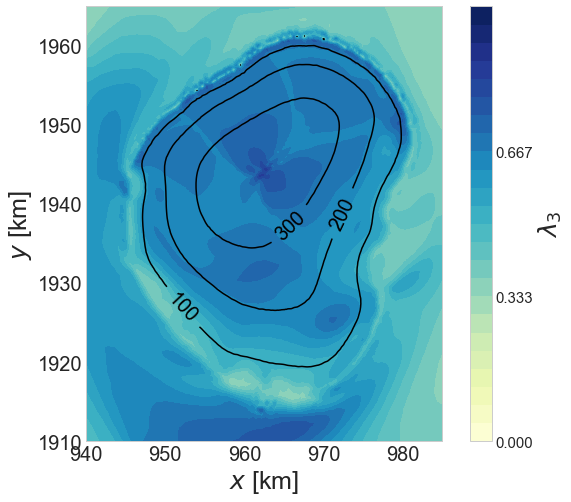

In [31]:
 
inter = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, a_lambda3['Age0'], levels=np.linspace(0,1,25),  cmap='YlGnBu')
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax.clabel(CS2, inline=True, fontsize=20, colors=['black'])
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_aspect('equal')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
cbar = fig.colorbar(CS, ticks=[0.0, 0.333, 0.667])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\lambda_3$", rotation=90, size=25)
fig.savefig('../../Figures/lambda3_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/1580111524.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0.0, 0.1, 0.2, 0.3])


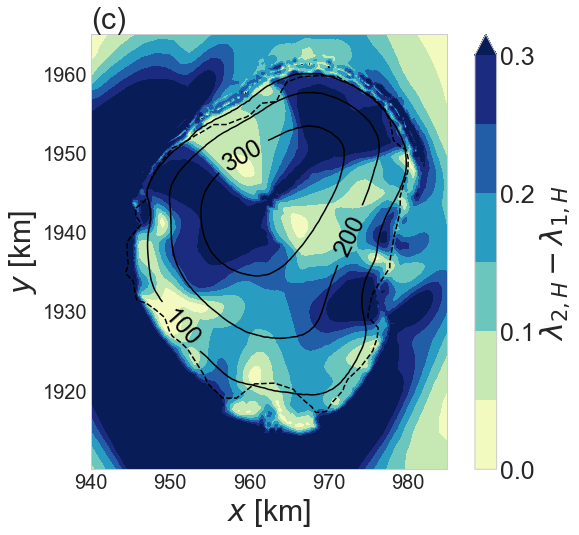

In [48]:
a_lambda2_1_H

 
inter = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, a_lambda2_1_H['Age0'], levels=np.linspace(0,0.3,7),  cmap='YlGnBu', extend='max')
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax.clabel(CS2, inline=True, fontsize=25, colors=['black'])
ax.plot(hull_pts[0], hull_pts[1], linestyle="--", color='black')
ax.set_xlabel(r'$x$ [km]', size=30)
ax.set_ylabel(r'$y$ [km]', size=30)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_aspect('equal')
ax.set_title(label, size=30, loc='left')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
ax.set_xticks([940, 950, 960, 970, 980])
ax.set_yticks([1920, 1930, 1940, 1950, 1960])
cbar = fig.colorbar(CS, ticks=[0.0, 0.1, 0.2, 0.3])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r"$\lambda_{2,H} - \lambda_{1,H}$", rotation=90, size=30)
fig.savefig('../../Figures/a_lambda2_1_H_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/890865583.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0, 5, 10, 15, 20])


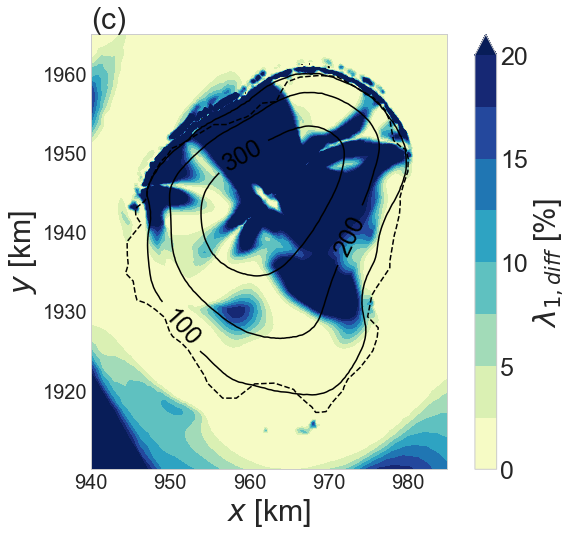

In [33]:
 
inter = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, -a_lambda1_perc_subtract['Age0'], levels=np.linspace(0,20,9),  cmap='YlGnBu', extend="max")
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax.plot(hull_pts[0], hull_pts[1], linestyle="--", color='black')
ax.clabel(CS2, inline=True, fontsize=25, colors=['black'])
ax.set_xlabel(r'$x$ [km]', size=30)
ax.set_ylabel(r'$y$ [km]', size=30)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_aspect('equal')
ax.set_title(label, size=30, loc='left')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
ax.set_yticks([1920, 1930, 1940, 1950, 1960])
cbar = fig.colorbar(CS, ticks=[0, 5, 10, 15, 20])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r'$\lambda_{1,diff}$ [%]', rotation=90, size=30)
fig.savefig('../../Figures/lambda1_perc_diff_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/2885546172.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0, 5, 10, 15, 20])


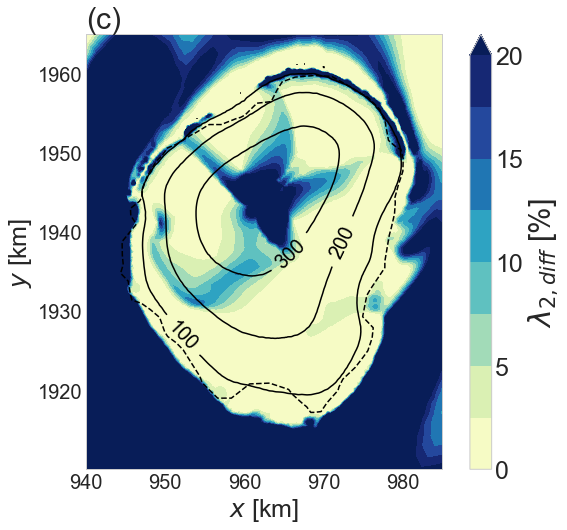

In [34]:
 
inter = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, -a_lambda2_perc_subtract['Age0'], levels=np.linspace(0,20,9),  cmap='YlGnBu', extend="max")
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax.plot(hull_pts[0], hull_pts[1], linestyle="--", color='black')
ax.clabel(CS2, inline=True, fontsize=20, colors=['black'])
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_aspect('equal')
ax.set_title(label, size=30, loc='left')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
ax.set_yticks([1920, 1930, 1940, 1950, 1960])
cbar = fig.colorbar(CS, ticks=[0, 5, 10, 15, 20])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r'$\lambda_{2,diff}$ [%]', rotation=90, size=30)
fig.savefig('../../Figures/lambda2_perc_diff_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/837109565.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


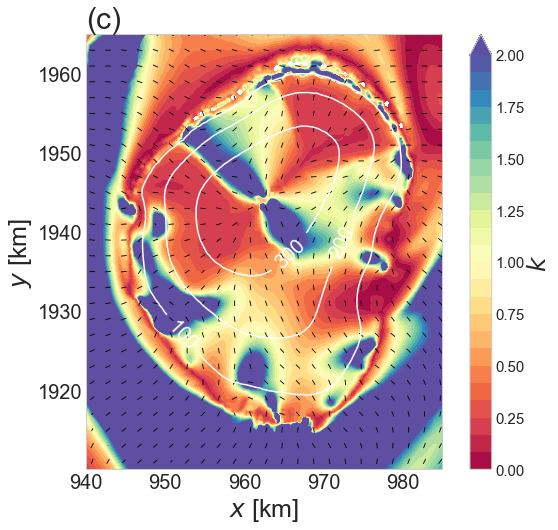

In [35]:

inter = 20
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, k['Age0'], levels=np.linspace(0,2,25),  cmap='Spectral', extend="max")
skip = (slice(None, None, inter), slice(None, None, inter))
ax.quiver(grid_x[skip]/1000, grid_y[skip]/1000, a_ev2x_H['Age0'][skip], a_ev2y_H['Age0'][skip], pivot='mid', headlength=0, headwidth=1)
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['white'])
ax.clabel(CS2, inline=True, fontsize=20, colors=['white'])
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_aspect('equal')
ax.set_title(label, size=30, loc='left')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
ax.set_xticks([940, 950, 960, 970, 980])
ax.set_yticks([1920, 1930, 1940, 1950, 1960])
cbar = fig.colorbar(CS)
#cbar = fig.colorbar(CS, ticks=[-0.005, -0.0025, 0.0, 0.0025, 0.005])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$k$', rotation=90, size=25)
fig.savefig('../../Figures/k_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/1341968214.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[-2, -1, 0, 1, 2])


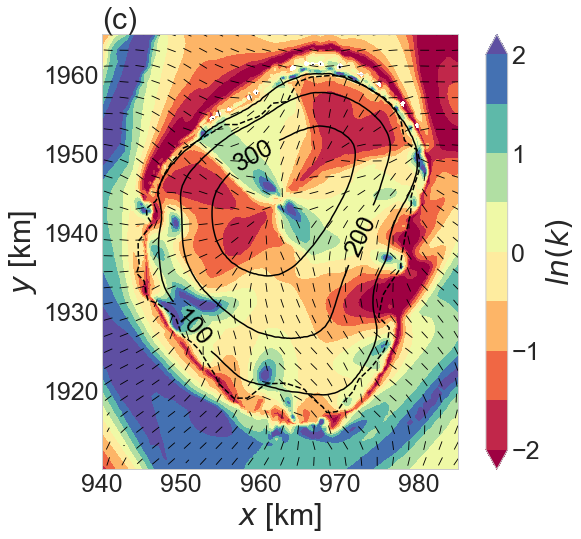

In [36]:

inter = 20
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, lnk['Age0'], levels=np.linspace(-2,2,9),  cmap='Spectral', extend="both")
skip = (slice(None, None, inter), slice(None, None, inter))
ax.quiver(grid_x[skip]/1000, grid_y[skip]/1000, a_ev2x_H['Age0'][skip], a_ev2y_H['Age0'][skip], pivot='mid', headlength=0, headwidth=1, scale=40)
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax.plot(hull_pts[0], hull_pts[1], linestyle="--", color='black')
ax.clabel(CS2, inline=True, fontsize=25, colors=['black'])
ax.set_xlabel(r'$x$ [km]', size=30)
ax.set_ylabel(r'$y$ [km]', size=30)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_aspect('equal')
ax.set_title(label, size=30, loc='left')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
ax.set_xticks([940, 950, 960, 970, 980])
ax.set_yticks([1920, 1930, 1940, 1950, 1960])
cbar = fig.colorbar(CS, ticks=[-2, -1, 0, 1, 2])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r'$ln(k)$', rotation=90, size=30)
fig.savefig('../../Figures/lnk_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/2351335702.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0, 1, 2, 3, 4])


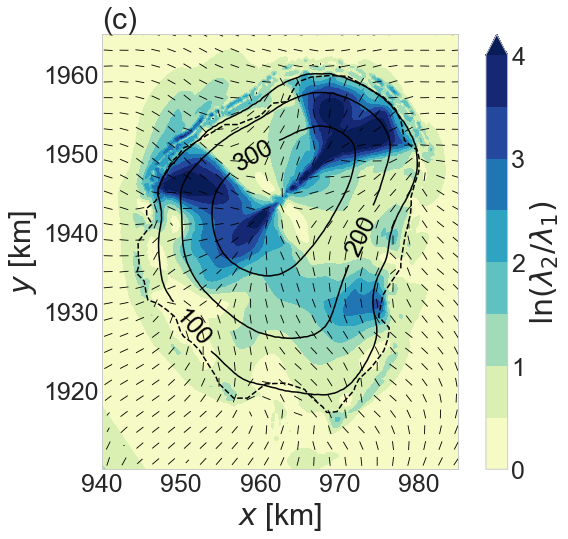

In [37]:

inter = 20
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, girdle['Age0'], levels=np.linspace(0,4,9),  cmap='YlGnBu', extend="max")
skip = (slice(None, None, inter), slice(None, None, inter))
ax.quiver(grid_x[skip]/1000, grid_y[skip]/1000, a_ev2x_H['Age0'][skip], a_ev2y_H['Age0'][skip], pivot='mid', headlength=0, headwidth=1, scale=40)
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax.clabel(CS2, inline=True, fontsize=25, colors=['black'])
ax.plot(hull_pts[0], hull_pts[1], linestyle="--", color='black')
ax.set_xlabel(r'$x$ [km]', size=30)
ax.set_ylabel(r'$y$ [km]', size=30)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_aspect('equal')
ax.set_title(label, size=30, loc='left')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
ax.set_xticks([940, 950, 960, 970, 980])
ax.set_yticks([1920, 1930, 1940, 1950, 1960])
cbar = fig.colorbar(CS, ticks=[0, 1, 2, 3, 4])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r'$\ln(\lambda_2 / \lambda_1)$', rotation=90, size=30)
fig.savefig('../../Figures/girdle_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/3917302054.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS, ticks=[0, 1, 2, 3, 4])


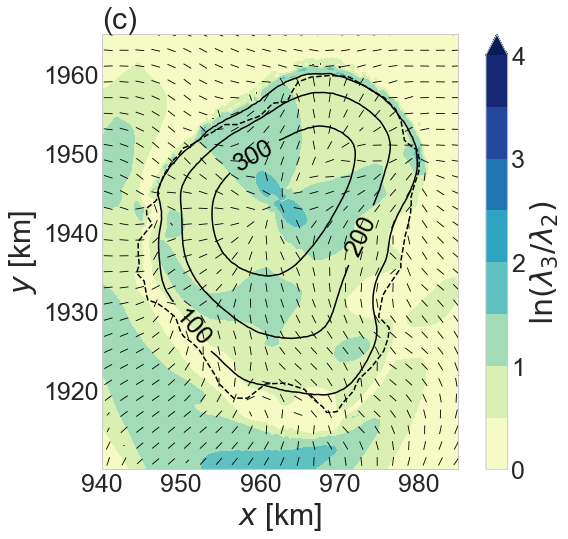

In [38]:

inter = 20
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#CS = ax.contourf(x/1000, y/1000, single_max['Age0'], levels=np.linspace(0,4,25),  cmap=truncate_colormap(plt.get_cmap('Spectral'), 0.5, 1.0), extend="max")
CS = ax.contourf(x/1000, y/1000, single_max['Age0'], levels=np.linspace(0,4,9),  cmap='YlGnBu', extend="max")
skip = (slice(None, None, inter), slice(None, None, inter))
ax.quiver(grid_x[skip]/1000, grid_y[skip]/1000, a_ev2x_H['Age0'][skip], a_ev2y_H['Age0'][skip], pivot='mid', headlength=0, headwidth=1, scale=40)
CS2 = ax.contour(x/1000, y/1000, depth['Age0'], levels=np.linspace(0,400,5), colors=['black'])
ax.clabel(CS2, inline=True, fontsize=25, colors=['black'])
ax.plot(hull_pts[0], hull_pts[1], linestyle="--", color='black')
ax.set_xlabel(r'$x$ [km]', size=30)
ax.set_ylabel(r'$y$ [km]', size=30)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_aspect('equal')
ax.set_title(label, size=30, loc='left')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
ax.set_xticks([940, 950, 960, 970, 980])
ax.set_yticks([1920, 1930, 1940, 1950, 1960])
cbar = fig.colorbar(CS, ticks=[0, 1, 2, 3, 4])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r'$\ln(\lambda_3 / \lambda_2)$', rotation=90, size=30)
fig.savefig('../../Figures/single_max_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/2310611825.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


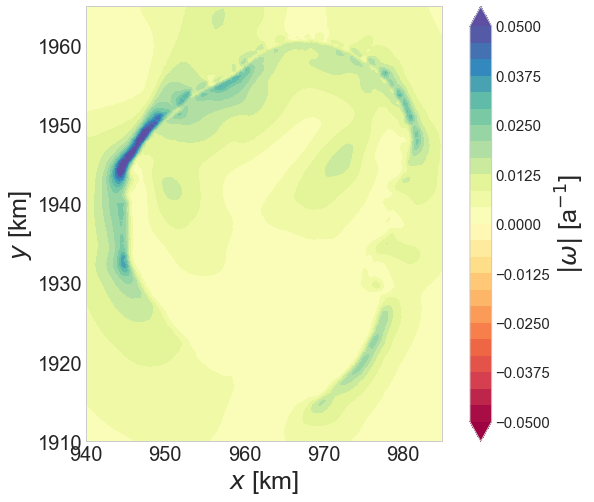

In [39]:

inter = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, w_mag['Age0'], levels=np.linspace(-0.05,0.05,25),  cmap='Spectral', extend="both")
skip = (slice(None, None, inter), slice(None, None, inter))
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_aspect('equal')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
cbar = fig.colorbar(CS)
#cbar = fig.colorbar(CS, ticks=[-0.005, -0.0025, 0.0, 0.0025, 0.005])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r'$|\omega|$ [a$^{-1}$]', rotation=90, size=25)
fig.savefig('../../Figures/w_mag_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/727680633.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


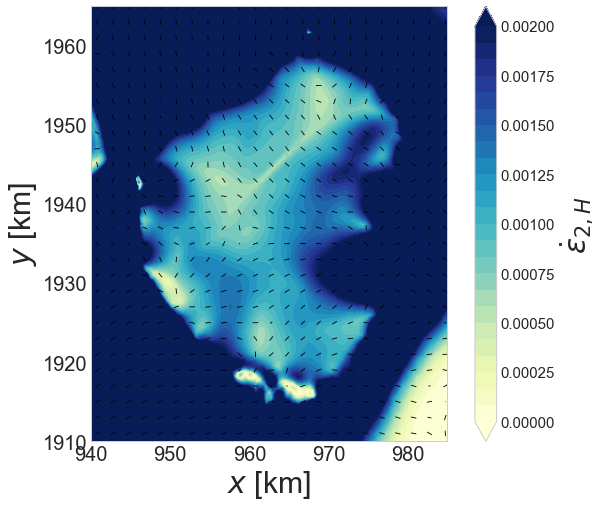

In [40]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
skip = (slice(None, None, 20), slice(None, None, 20))
CS = ax.contourf(x/1000, y/1000, np.absolute(d_lambda2_H['Age0']), levels=np.linspace(0,0.002,25),  cmap='YlGnBu', extend="both")
ax.quiver(grid_x[skip]/1000, grid_y[skip]/1000, d_ev2x_H['Age0'][skip], d_ev2y_H['Age0'][skip], pivot='mid', headlength=0, headwidth=1)
ax.set_aspect('equal')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel(r'$x$ [km]', size=30)
ax.set_ylabel(r'$y$ [km]', size=30)
cbar = fig.colorbar(CS)
cbar.set_label(r'$\dot{\varepsilon}_{2,H}$', size=30)
cbar.ax.tick_params(labelsize=15)
fig.savefig('../../Figures/d_lambda2_H_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/1512732127.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


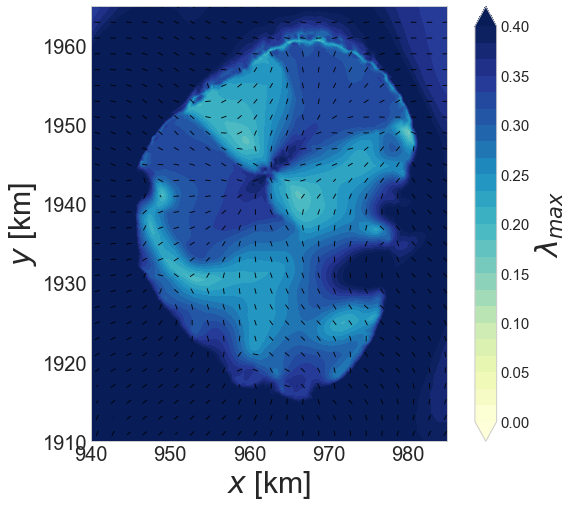

In [41]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
skip = (slice(None, None, 20), slice(None, None, 20))
CS = ax.contourf(x/1000, y/1000, np.absolute(a_lambda2_H['Age0']), levels=np.linspace(0,0.4,25), cmap='YlGnBu', extend="both")
ax.quiver(grid_x[skip]/1000, grid_y[skip]/1000, a_ev2x_H['Age0'][skip], a_ev2y_H['Age0'][skip], pivot='mid', headlength=0, headwidth=1)
ax.set_aspect('equal')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel(r'$x$ [km]', size=30)
ax.set_ylabel(r'$y$ [km]', size=30)
cbar = fig.colorbar(CS)
cbar.set_label(r'$\lambda_{max}$', size=30)
cbar.ax.tick_params(labelsize=15)
fig.savefig('../../Figures/a_lambda2_H_z0' + sim + '.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/2653522672.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


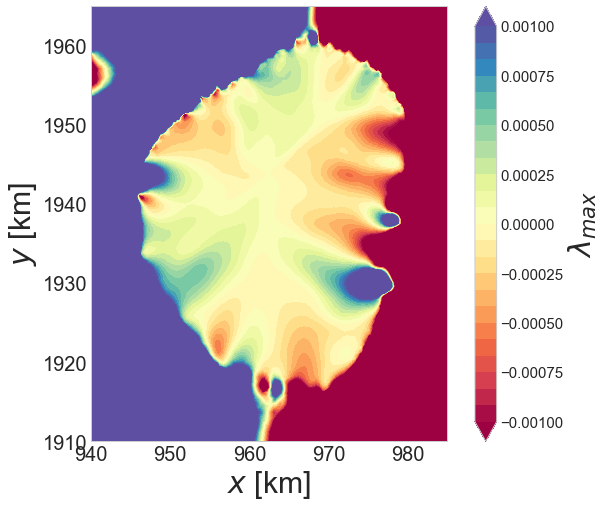

In [42]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, w1['Age0'], levels=np.linspace(-0.001,0.001,25), cmap='Spectral', extend="both")
ax.set_aspect('equal')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel(r'$x$ [km]', size=30)
ax.set_ylabel(r'$y$ [km]', size=30)
cbar = fig.colorbar(CS)
cbar.set_label(r'$\lambda_{max}$', size=30)
cbar.ax.tick_params(labelsize=15)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_33266/716539119.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(CS)


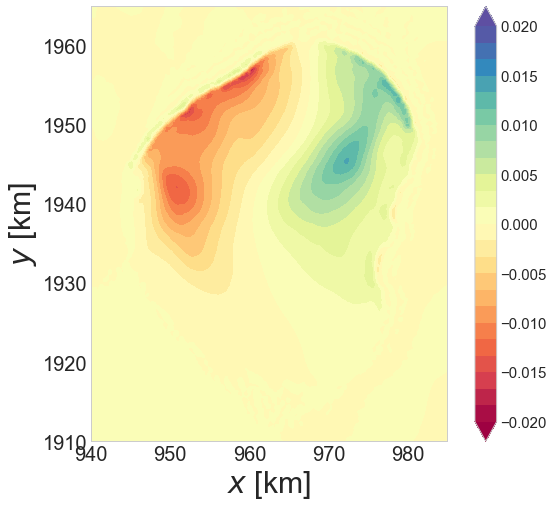

In [43]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, w2['Age0'], levels=np.linspace(-0.02,0.02,25), cmap='Spectral', extend="both")
ax.set_aspect('equal')
plt.xlim(940, 985)
plt.ylim(1910, 1965)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel(r'$x$ [km]', size=30)
ax.set_ylabel(r'$y$ [km]', size=30)
cbar = fig.colorbar(CS)
#cbar.set_label(r'$\lambda_{max}$', size=30)
cbar.ax.tick_params(labelsize=15)
